In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator



pd.set_option('display.max_rows', None)


with open('/scratch_tmp/users/k2480846/storage_analysis/data/quota_report.txt', 'r') as file:
    lines = file.readlines()


cleaned_lines = []
for line in lines:
    if not line.startswith('-') and 'Path' not in line:
        cleaned_lines.append(line.strip())

quota_report = [line.split(maxsplit=6) for line in cleaned_lines]


quota_report = pd.DataFrame(quota_report, columns=[
    "Path",
    "Type",
    "Quota (GB)",
    "Usage (GB)",
    "Available (GB)",
    "Usage (%)",
    "Updated"
])
quota_report["Path"] = quota_report["Path"].str.replace(r"^/scratch/(prj|grp)/", "", regex=True)
quota_report["Quota (GB)"] = pd.to_numeric(quota_report["Quota (GB)"])
quota_report["Usage (GB)"] = pd.to_numeric(quota_report["Usage (GB)"])
quota_report["Available (GB)"] = pd.to_numeric(quota_report["Available (GB)"])
quota_report["Usage (GB)"] = pd.to_numeric(quota_report["Usage (GB)"])


free_projects = quota_report[(quota_report["Quota (GB)"]>=1000) & (quota_report["Quota (GB)"] <= 1024)]

paid_for_projects = quota_report[quota_report["Quota (GB)"]>1024]

paid_for_projects_free_tier_storage = len(paid_for_projects) * 1000
paid_for_projects_total_storage = float(paid_for_projects["Quota (GB)"].sum())
paid_for_projects_paid_storage = paid_for_projects_total_storage - paid_for_projects_free_tier_storage

## usage (GB) for paid projects
used_storage_paid_for_projects = float(paid_for_projects["Usage (GB)"].sum())
unused_storage_paid_for_projects = paid_for_projects_total_storage - float(used_storage_paid_for_projects)


In [2]:
## rosalind group quotas

def convert_storage(value):
    if value.endswith('T'): 
        return float(value.rstrip('T')) * 1000
    elif value.endswith('G'): 
        return float(value.rstrip('G'))
    elif value.endswith('k'):
        return float(value.rstrip('k'))
    else:
        return float(value)

def get_not_covered_by_rosalind(ceph_quota, covered_by_rosalind):
    if(ceph_quota > covered_by_rosalind):
        return ceph_quota - covered_by_rosalind
    else:
        return 0  

rosalind_quotas = pd.read_excel('/scratch_tmp/users/k2480846/storage_analysis/data/rosalind_group_quotas.ods', engine='odf')
rosalind_quotas["quota"] = rosalind_quotas["quota"].apply(convert_storage)
rosalind_quotas["Rosalind Quota"] = rosalind_quotas["quota"]
rosalind_quotas = rosalind_quotas.drop(columns=['gid','filesys','group','grace','files_used','files_quota','files_grace', 'files_limit','limit','used', 'quota'])


merged_df = pd.merge(quota_report, rosalind_quotas, left_on="Path", right_on="dir", how="outer")
merged_df = merged_df.dropna(subset=["dir","Path"])
merged_df["Covered by Rosalind"] = merged_df[["Quota (GB)", "Rosalind Quota"]].min(axis=1)
merged_df["Not covered by Rosalind"] = merged_df.apply(lambda row : get_not_covered_by_rosalind(row["Quota (GB)"], row["Covered by Rosalind"]), axis=1)

storage_covered_from_migration_from_rosalind = float(merged_df["Covered by Rosalind"].sum())
storage_covered_from_migration_from_rosalind
storage_not_covered_from_migration_from_rosalind = float(merged_df["Not covered by Rosalind"].sum())


covered_completely_by_rosalind = merged_df[merged_df["Not covered by Rosalind"]==0]
covered_completely_by_rosalind


,Path,Type,Quota (GB),Usage (GB),Available (GB),Usage (%),Updated,dir,Rosalind Quota,Covered by Rosalind,Not covered by Rosalind
7,als_family,Group,2000.0,1133.0,867.0,56,2024-11-18 12:12:11,als_family,2000.0,2000.0,0.0
13,alspac,Group,1000.0,858.0,142.0,85,2024-11-18 12:12:11,alspac,1000.0,1000.0,0.0
150,derm_ukb,Group,3000.0,2883.0,117.0,96,2024-11-18 12:12:26,derm_ukb,3000.0,3000.0,0.0
212,groupfogh,Group,5000.0,4716.0,284.0,94,2024-11-18 12:12:32,groupfogh,5000.0,5000.0,0.0
214,groupso,Group,5000.0,3410.0,1590.0,68,2024-11-18 12:12:32,groupso,17000.0,5000.0,0.0
234,gwas_sumstats,Group,8000.0,7985.0,15.0,99,2024-11-18 12:12:32,gwas_sumstats,8000.0,8000.0,0.0
235,gwased,Group,3000.0,548.0,2452.0,18,2024-11-18 12:12:32,gwased,3000.0,3000.0,0.0
241,herv_msc,Group,4000.0,3985.0,15.0,99,2024-11-18 12:12:33,herv_msc,4000.0,4000.0,0.0
246,hodgkinsonlab,Group,160000.0,148025.0,11975.0,92,2024-11-19 16:40:19,hodgkinsonlab,312000.0,160000.0,0.0
320,knightlab,Group,1000.0,215.0,785.0,21,2024-11-18 12:12:42,knightlab,1000.0,1000.0,0.0


In [3]:
## recharging register shenanigans

import openpyxl

xl = pd.ExcelFile('/scratch_tmp/users/k2480846/storage_analysis/data/recharging_register.xlsx')
recharging_register = xl.parse("Current projects")
recharging_register["Countdown"] = recharging_register["Countdown"].str.replace(r' days| DAYS', '', regex=True).astype(float)

pending_payment_projects = recharging_register[recharging_register["Countdown"]<0]

up_to_date_projects = recharging_register[recharging_register["Countdown"]>0]

Text(0.5, 1.0, 'Distribution of storage covered by migration from Rosalind and storage not covered')

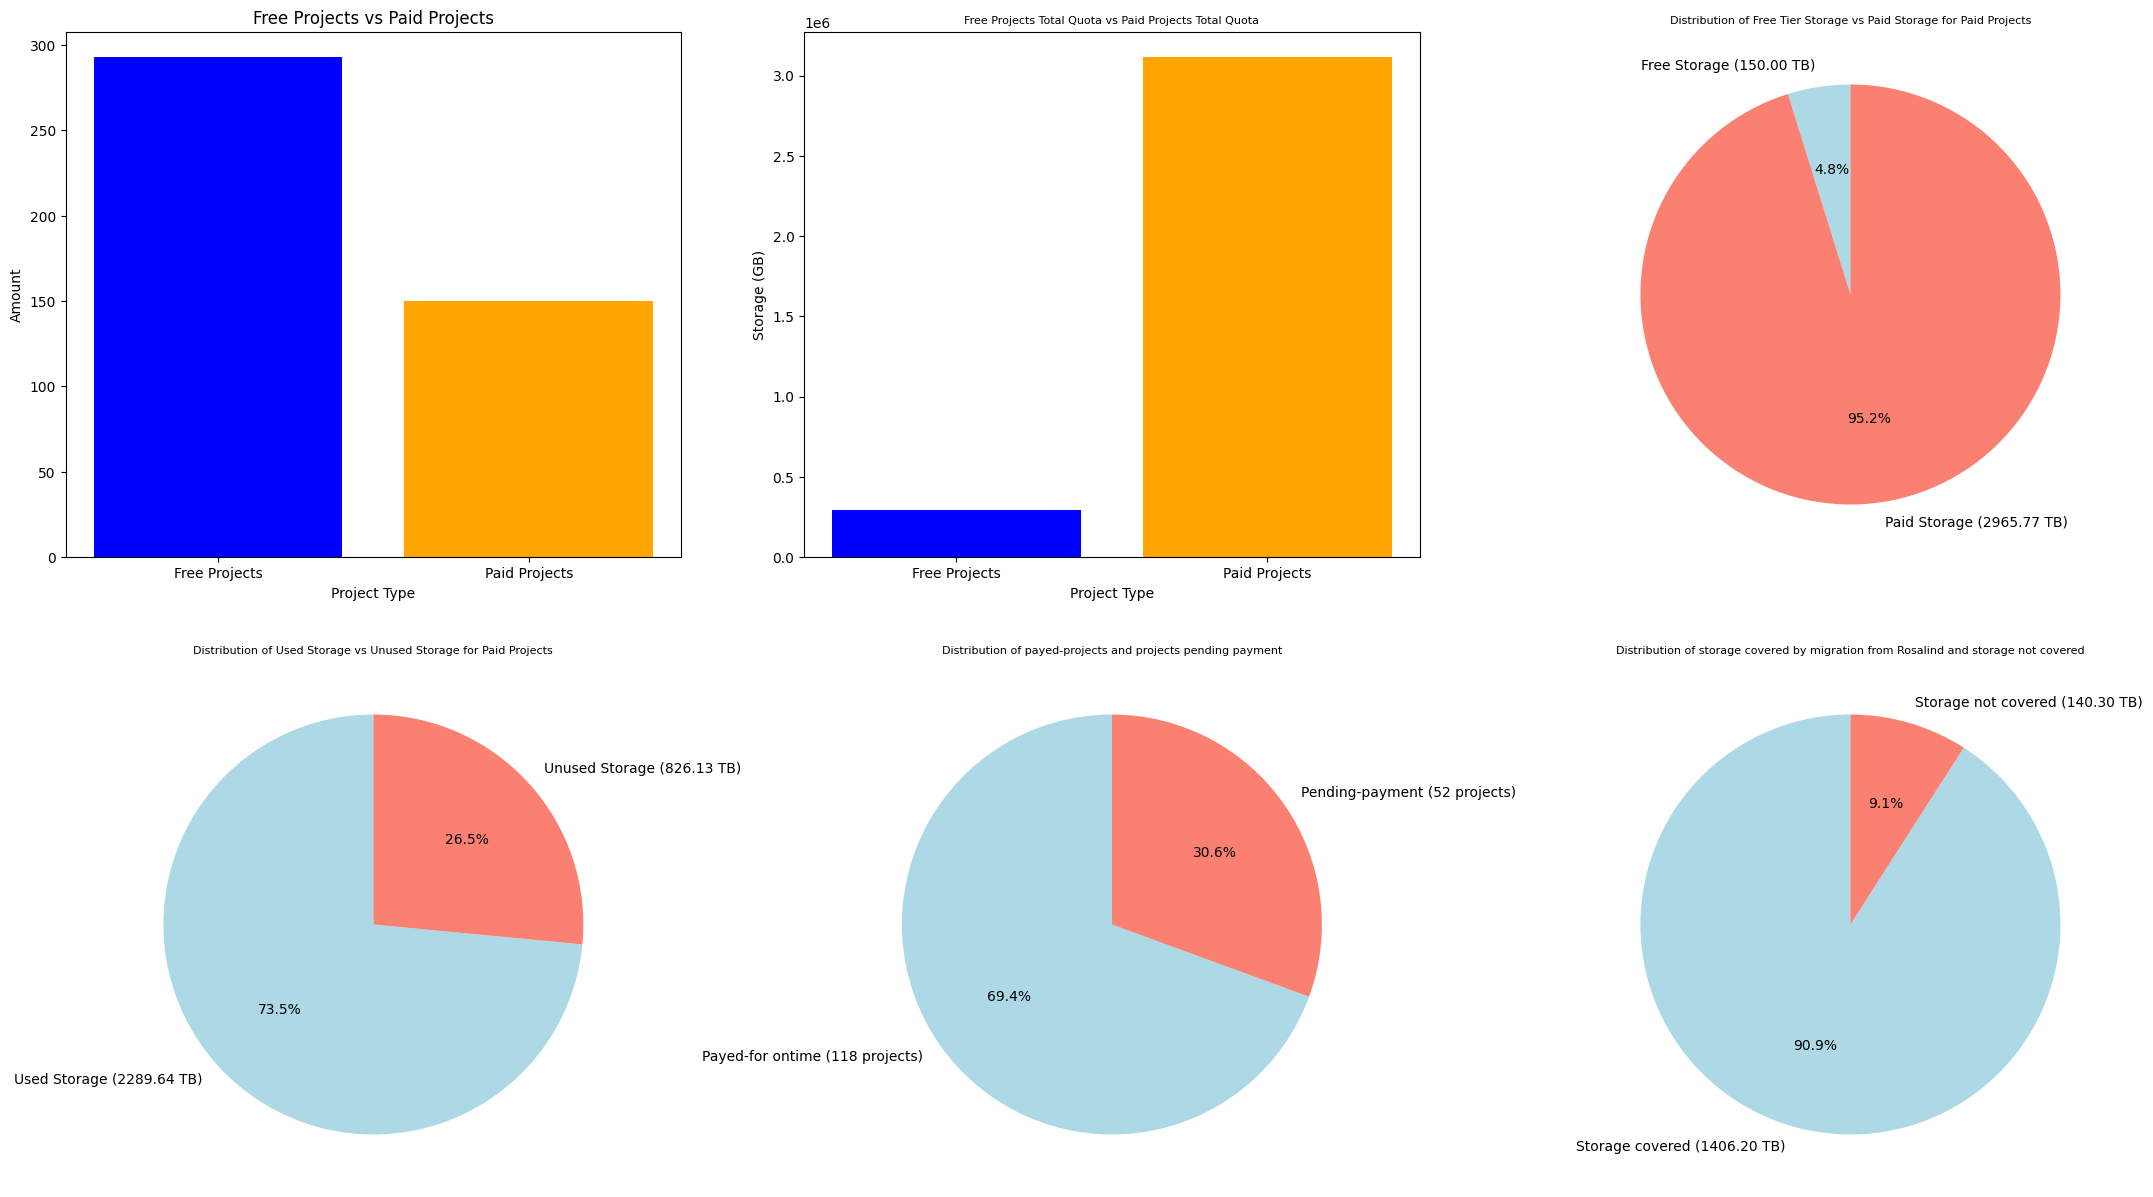

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(27, 15)) 

axes[0, 0].bar(['Free Projects', 'Paid Projects'], 
               [len(free_projects), len(paid_for_projects)], 
               color=['blue', 'orange'])
axes[0, 0].set_title("Free Projects vs Paid Projects")
axes[0, 0].set_ylabel("Amount")
axes[0, 0].set_xlabel("Project Type")

axes[0, 1].bar(['Free Projects', 'Paid Projects'], 
               [float(free_projects["Quota (GB)"].sum()), paid_for_projects_total_storage], 
               color=['blue', 'orange'])
axes[0, 1].set_title("Free Projects Total Quota vs Paid Projects Total Quota", fontsize=8)
axes[0, 1].set_ylabel("Storage (GB)")
axes[0, 1].set_xlabel("Project Type")

axes[0, 2].pie([paid_for_projects_free_tier_storage, paid_for_projects_paid_storage], 
               labels=[
                f'Free Storage ({paid_for_projects_free_tier_storage /1000 :.2f} TB)',
                f'Paid Storage ({paid_for_projects_paid_storage /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[0, 2].set_title("Distribution of Free Tier Storage vs Paid Storage for Paid Projects", fontsize=8)


axes[1, 0].pie([used_storage_paid_for_projects, unused_storage_paid_for_projects], 
               labels=[
                f'Used Storage ({used_storage_paid_for_projects /1000 :.2f} TB)', 
                f'Unused Storage ({unused_storage_paid_for_projects /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 0].set_title("Distribution of Used Storage vs Unused Storage for Paid Projects", fontsize=8)


axes[1, 1].pie([len(up_to_date_projects), len(pending_payment_projects)], 
               labels=[
                f'Payed-for ontime ({len(up_to_date_projects)} projects)', 
                f'Pending-payment ({len(pending_payment_projects)} projects)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 1].set_title("Distribution of payed-projects and projects pending payment", fontsize=8)

axes[1, 2].pie([storage_covered_from_migration_from_rosalind, storage_not_covered_from_migration_from_rosalind], 
               labels=[
                f'Storage covered ({storage_covered_from_migration_from_rosalind /1000 :.2f} TB)', 
                f'Storage not covered ({storage_not_covered_from_migration_from_rosalind /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 2].set_title("Distribution of storage covered by migration from Rosalind and storage not covered", fontsize=8)
